In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd





In [91]:
from sklearn import preprocessing


df = pd.read_csv('titanic.csv')
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

dummies = pd.get_dummies(df)
dummies = dummies.dropna(subset=['Age'])
min_max_scaler = preprocessing.MinMaxScaler()
dummies[['Fare', 'Age']] = min_max_scaler.fit_transform(dummies[['Fare', 'Age']])
dummies[dummies.isna().any(axis=1)]




,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S


In [92]:
dummies[dummies.isna().any(axis=1)]


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S


In [93]:
dummies.head()


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,0.271174,1,0,0.014151,False,True,False,False,True
1,1,1,0.472229,1,0,0.139136,True,False,True,False,False
2,1,3,0.321438,0,0,0.015469,True,False,False,False,True
3,1,1,0.434531,1,0,0.103644,True,False,False,False,True
4,0,3,0.434531,0,0,0.015713,False,True,False,False,True


In [94]:
from sklearn.model_selection import train_test_split

X = dummies.drop('Survived', axis=1)
y = dummies['Survived']

# Convertir columnas bool a float
X = X.astype(float)

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X.dtypes)


import torch

# Convertir a tensores float
x_train = torch.tensor(x_train.values, dtype=torch.float32)
x_test  = torch.tensor(x_test.values, dtype=torch.float32)

y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test  = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)



Pclass        float64
Age           float64
SibSp         float64
Parch         float64
Fare          float64
Sex_female    float64
Sex_male      float64
Embarked_C    float64
Embarked_Q    float64
Embarked_S    float64
dtype: object


In [95]:

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(10,10)
        self.fc2 = nn.Linear(10,5)
        self.fc3 = nn.Linear(5,1)

    def forward(self, x):
        x = F.relu(self.fc1(x))       # primera capa + ReLU
        x = F.relu(self.fc2(x))       # segunda capa + ReLU
# Apply ReLU activation to hidden layer output
        x = F.sigmoid(self.fc3(x))

        return x


In [96]:
model = MLP()
loss_fn = nn.BCELoss() # Para clasificación binaria
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPISODIO = 1000



In [97]:
import copy
from sklearn.metrics import accuracy_score

best_acc = 0
best_weights = None

losses = []
accuracy = []

acc_train = []

for epoch in range(EPISODIO):
    model.train()
    output = model(x_train)
    loss = loss_fn(output, y_train.reshape(-1, 1))

    losses.append(loss.detach().numpy())

    loss.backward()
    optimizer.step()

    model.eval()
    output_val = model(x_test)

    acc = accuracy_score(y_train, (output.detach() > 0.5).int())
    acc_train.append(acc)
    acc_val = accuracy_score(y_test, (output_val.detach() > 0.5).int())

    if acc_val > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())

    accuracy.append(acc_val)
model.load_state_dict(best_weights);

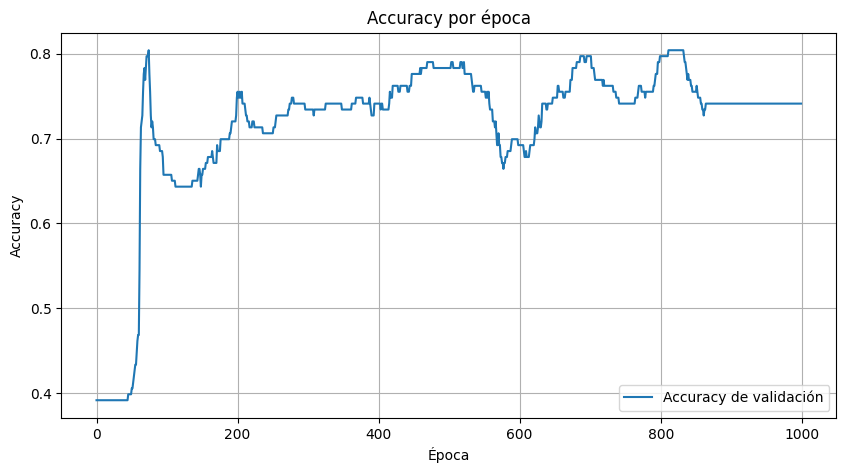

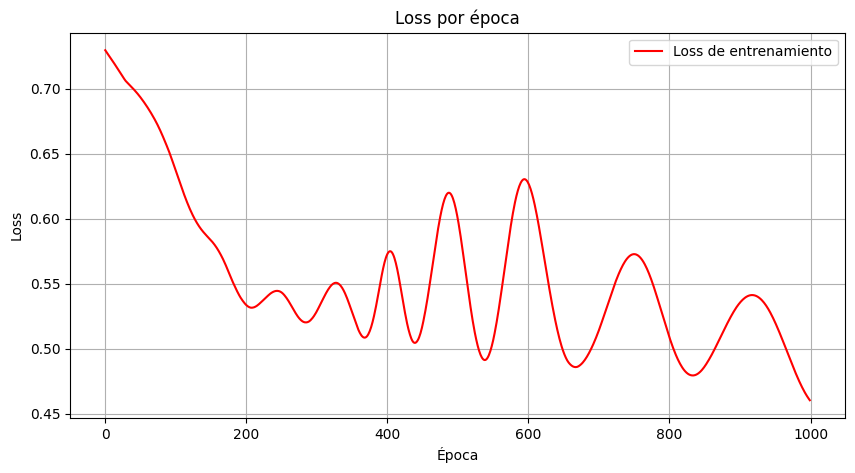

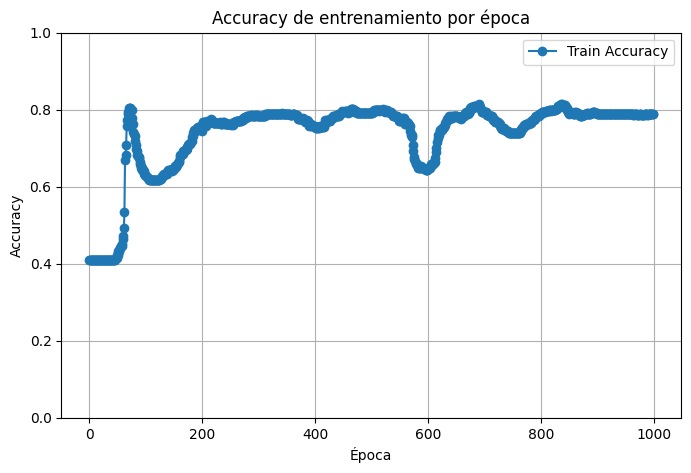

In [98]:
import matplotlib.pyplot as plt

# Visualizar accuracy
plt.figure(figsize=(10,5))
plt.plot(range(EPISODIO), accuracy, label='Accuracy de validación')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('Accuracy por época')
plt.legend()
plt.grid(True)
plt.show()

# Visualizar pérdidas
plt.figure(figsize=(10,5))
plt.plot(range(EPISODIO), losses, label='Loss de entrenamiento', color='red')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Loss por época')
plt.legend()
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt

# Supongamos que tienes acc_train como lista con la accuracy por época
# acc_train = [...]

plt.figure(figsize=(8,5))
plt.plot(range(EPISODIO), acc_train, marker='o', label='Train Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('Accuracy de entrenamiento por época')
plt.ylim(0,1)  # Para que vaya de 0 a 1
plt.grid(True)
plt.legend()
plt.show()

